### Downloading necessary dependencies

In [ ]:
!pip install wget tensorflow==1.5 pandas numpy keras

     |████████████████████████████████| 44.4MB 91kB/s 
     |████████████████████████████████| 3.0MB 46.3MB/s 
     |████████████████████████████████| 890kB 40.7MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d63af8f3f67d8d81b49e841465a54c5c64140ea573751d0c869afef395400c43
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=c7cb1ba9dadf712e8e65256f2f34885c0df35683d02f77d081fb71c498c21c2e
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built wget html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorf

### Downloading CLINC150 Dataset and Glove word vector

In [ ]:
import wget
url = 'https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json'
wget.download(url)

url = 'https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

'glove.6B.100d.txt'

### Dataset preparing

In [ ]:
import numpy as np
import json

In [ ]:
# Loading json data
with open('data_full.json') as file:
  data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])

In [ ]:
data = np.concatenate([train,test,val])
data = data.T

text = data[0]
labels = data[1]

###Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.3)

### Preprocessing split dataset

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

In [ ]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))

In [ ]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.004451992, 0.4081574)

In [ ]:
max_num_words = 40000
embedding_dim=len(embeddings_index['the'])
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)

train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')
word_index = tokenizer.word_index

In [ ]:
num_words = min(max_num_words, len(word_index) )+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [ ]:
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)

In [ ]:
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

### Model preparation

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding

In [ ]:
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           631600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         731136    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
dro

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Train on 16590 samples, validate on 7110 samples
Epoch 1/20
16590/16590 [==============================]16590/16590 [==============================] - 237s 14ms/step - loss: 4.6607 - acc: 0.0450 - val_loss: 3.9508 - val_acc: 0.0852

Epoch 2/20
16590/16590 [==============================]16590/16590 [==============================] - 236s 14ms/step - loss: 3.4791 - acc: 0.1338 - val_loss: 2.4597 - val_acc: 0.3428

Epoch 3/20
16590/16590 [==============================]16590/16590 [==============================] - 236s 14ms/step - loss: 2.4155 - acc: 0.3322 - val_loss: 1.6255 - val_acc: 0.5473

Epoch 4/20
16590/16590 [==============================]16590/16590 [==============================] - 236s 14ms/step - loss: 1.7686 - acc: 0.4929 - val_loss: 1.1907 - val_acc: 0.6586

Epoch 5/20
16590/16590 [==============================]16590/16590 [==============================] - 236s 14ms/step - loss: 1.3704 - acc: 0.6024 - val_loss: 0.9433 - val_acc: 0.7239

Epoch 6/20
16590/16590 [=======

### Metrics visualization

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

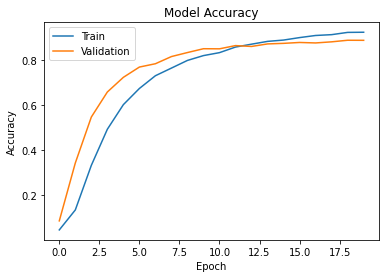

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

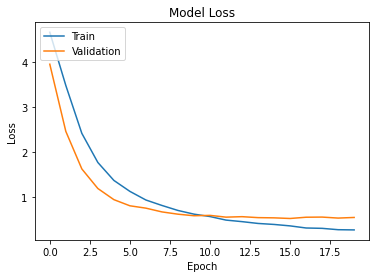

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Saving Model, Tokenizer, Label Encoder and Labels

In [ ]:
import pickle
import json

In [ ]:
model.save('models/intents.h5')

with open('utils/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('utils/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('utils/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

### Predicting on real-time examples

In [ ]:
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [ ]:
import pickle

from tensorflow.python.keras.models import load_model

model = load_model('models/intents.h5')

with open('utils/classes.pkl','rb') as file:
  classes = pickle.load(file)

with open('utils/tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('utils/label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

In [ ]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)

In [ ]:
nlu.get_intent("is it cold in India right now")

'weather'